# SDSS-V Fiber Positioner Robot Array Map

Given an FPS robot configuration file, make plots of the focal plane configuration.

## Modules and functions we need

Collection of convenience functions for repeated operations mostly related to plotting.

In [1]:
import sys
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Plot a donut with given inner and outer radii

def plotPatrol(ax,xc,yc,r1,r2,color,mc,alpha=1.0):
    n,radii = 60,[r1,r2]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = xc + np.outer(radii, np.cos(theta))
    ys = yc + np.outer(radii, np.sin(theta))

    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]

    ax.fill(np.ravel(xs), np.ravel(ys), color=color, alpha=alpha)
    #ax.plot(xc,yc,marker="+",color=mc,markersize=10,zorder=10)

# Plot an unfileld circle of a given radius

def plotCircle(ax,xc,yc,r,color,ltype='-',alpha=0):
    theta = np.linspace(0,2*np.pi,360,endpoint=True)
    xs = xc + r*np.cos(theta)
    ys = yc + r*np.sin(theta)
    ax.plot(xs,ys,linestyle=ltype,color=color,alpha=alpha,lw=1.0)

# Plot a fiducial circle of a given radius
# FIF tips are 3mm in diameter -> 1.5mm in radius

def plotFiducial(ax,xc,yc,color,alpha=0):
    rFid = 1.5 # nominal fiducial head radius in mm
    rExc = 2.0*rFid # exclusion zone radius around the fiducial = 2x physical radius
    theta = np.linspace(0,2*np.pi,360,endpoint=True)
    xs = xc + rFid*np.cos(theta)
    ys = yc + rFid*np.sin(theta)
    xe = xc + rExc*np.cos(theta)
    ye = yc + rExc*np.sin(theta)
    ax.fill(xe,ye,color='white',alpha=alpha,zorder=10)
    ax.fill(xs,ys,color=color,alpha=alpha,zorder=10)
    ax.plot(xe,ye,linestyle='-',color='black',alpha=alpha)

# Plot an auxiliary instrument (e.g., On-Axis WFS Camera)

def plotAuxInst(ax,xc,yc,rad,fColor,eColor,alpha=0):
    theta = np.linspace(0,2*np.pi,360,endpoint=True)
    xs = xc + rad*np.cos(theta)
    ys = yc + rad*np.sin(theta)
    xe = xc + rad*np.cos(theta)
    ye = yc + rad*np.sin(theta)
    ax.fill(xe,ye,color=fColor,alpha=alpha,zorder=10)
    ax.plot(xe,ye,linestyle='-',color=eColor,alpha=alpha)

# 2D rotation matrix, because we need it

def rotXY(x,y,theta):
    sinth = np.sin(np.radians(theta))
    costh = np.cos(np.radians(theta))
    return x*costh-y*sinth, x*sinth+y*costh


## Robot Array Parameters

These parameters describe the baseline regular hexagonal array that we will later populate with robots and
fiducials.
 * n0 = number of positions along the central (0th) row of the hex array
 * ralpha = radius of the alpha arm of the robots in mm
 * rbeta = radius of the beta arm of the robots in mm, always >= ralpha
 * dFPS = diameter of the nominal focal plane in mm

From these we compute
 * pitch = spacing between robots, defined as ralpha+rbeta
 * r_inner = inner patrol radius (rbeta-ralpha)
 * r_outer = outer patrol radius (ralpha+rbeta)

In [2]:
# SDSS-V FPS Hexagonal Robot Array parameters

n0 = 29 # number of positions along the center (0th) row
ralpha = 7.4 # alpha arm radius in mm
rbeta = 15.0 # beta arm radius in mm
dFPS = 650.0 # nominal focal plane diameter in mm

# these are computed, only intervene with good reason

pitch = ralpha + rbeta
r_inner = rbeta - ralpha
r_outer = ralpha + rbeta
print("pitch: {} mm".format(pitch))
print("inner radius: {} mm".format(r_inner))
print("outer radius : {} mm".format(r_outer))

pitch: 22.4 mm
inner radius: 7.6 mm
outer radius : 22.4 mm


## GFA Camera placement

Define where we put the Guide/Focus/Acquisition (GFA) cameras around the periphery of the focal plane.
 * rGFA = radius of the camera centerline circle
 * thetaGFAs = clocking angle in degrees of each camera (CCW from x=0 axis)
 * gfaNumPix = number of pixels on the GFA detectors (assumes a square GFA camera)
 * gfaPixSize = pixel size of a GFA detector in millimeters 


In [3]:
# GFA Cameras

rGFA = 324.0 # radius of the GFA camera centerline relative to field center
thetaGFAs = [30.0,90.0,150.0,210.0,270.0,330.0]

# ML4720

#gfaNumPix = 1024
#gfaPixSize = 0.0135 # mm
#camBody = 94.0 # mm

# ML23042

#gfaNumPix = 2048
#gfaPixSize = 0.015 # mm

# ML4240
gfaNumPix = 2048
gfaPixSize = 0.0135 # mm

camBody = 100.0 # mm

## On-Axis WFS Camera

Depict the location of the on-axis Shack-Hartmann Wavefront Sensor (WFS) camera concept. The optics feed for the 
WFS is a fixed obstacle for robots to avoid.

The diameter of the WFS fore-optics and pinhole is the same 18-mm diameter as a robot body.

In [4]:
radWFS = 9.0 # mm radius, 18-mm diameter

## FPS Configuration file and plotting instructions

The configuration file, fpsFile, gives the locations of fiber positioner robots and their fiber payloads (BOSS,
APOGEE, or both), and the fiber-illuminated fiducials in the focal plane array.

The PNG plot file to create is plotFile.

plotWhat must be one of these:
 * all = plot all robots, color code by fiber payload
 * boss = plot only the BOSS-only fiber-carrying robots 
 * apogee = plot only the APOGEE fiber-carrying robots
 * bots = plot all of the robots, but don't color code by fiber payload
 
fps_DesignReference.txt is the design reference layout that we will build the flight systems to.

numPos=565 BOSS+APOGEE=298 BOSS-only=202 Fiducials=48


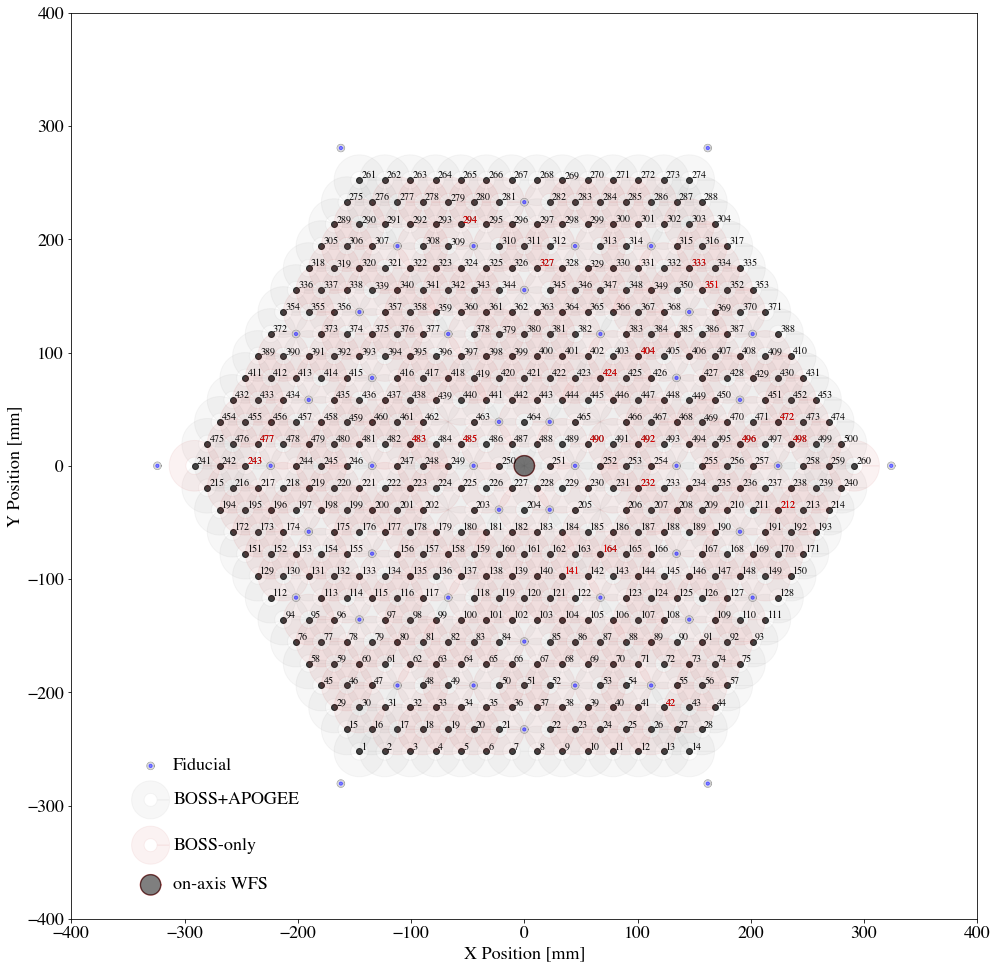

In [8]:
from astropy.table import Table
import matplotlib.font_manager as font_manager
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
font_prop = font_manager.FontProperties(size=18)
plt.rcParams["font.family"] = "Times"
# Configuration root name to use to build the configuration & plot filenames

fpsRootName = 'fps_DesignReference'

# Configuration filename

fpsFile = '%s.txt' % (fpsRootName)

# What to plot? one of [all,boss,apogee,bots]

plotWhat = 'all'

# Set flags and the plot filename

if plotWhat.lower() == 'all':
    plotBOSS = True
    justBots = False
    justBOSS = False
    plotFile = '%s.png' % (fpsRootName)
elif plotWhat.lower() == 'boss':
    plotBOSS = False
    justBots = False
    justBOSS = True
    plotFile = '%s_BOSS.png' % (fpsRootName)
elif plotWhat.lower() == 'apogee':
    plotBOSS = False
    justBots = False
    justBOSS = False
    plotFile = '%s_APOGEE.png' % (fpsRootName)
elif plotWhat.lower() == 'bots':
    plotBOSS = True
    justBots = True
    justBOSS = False
    plotFile = '%s_bots.png' % (fpsRootName)
else: # you meant all, didn't you?
    plotBOSS = True
    justBots = False
    justBOSS = False
    plotFile = '%s.png' % (fpsRootName)

#-----------------------------
#
# leave code below alone...
#

fontSize = 18
        
xPos = []
yPos = []
pType = []

numPos = 0
numBoss = 0
numBA = 0
numFid = 0
numAux = 0

if justBots:
    bossColor = "#666666"
    baColor = "#666666"
    fidColor = "blue"
else:
    bossColor = "#bb0000"
    baColor = "#666666"
    fidColor = "blue"

try:
    f = open(fpsFile,'r')
    fpsData = f.readlines()[::]
    f.close()
except:
    print("** Problems reading %s" % (fpsFile))
    f.close()
    sys.exit(1)

# Parse the fpsData contents

for line in fpsData:
    inStr = line.strip()
    if not (inStr.startswith("#") or len(inStr)==0):
        bits = inStr.split()
        xPos.append(float(bits[2]))
        yPos.append(float(bits[3]))
        pType.append(bits[4])

for i in range(len(xPos)):
    if pType[i] == 'Fiducial':
        numFid += 1
    elif pType[i] == 'BA':
        numBA += 1
    elif pType[i] == 'BOSS':
        numBoss += 1
    elif pType[i] == 'Aux':
        numAux += 1

print("numPos=%d BOSS+APOGEE=%d BOSS-only=%d Fiducials=%d" % (len(xPos),numBA,numBoss,numFid))
###
#Meg Processing Stuff
###
pType = np.array(pType)
xPos = np.array(xPos)
yPos = np.array(yPos)
BA_mask = np.where((pType == 'BOSS') | ((pType == 'BA')))[0]

sorted_x = []
sorted_y = []
robotID = []
n= 1
for i in np.unique(yPos[BA_mask]):
    for j in xPos[BA_mask][yPos[BA_mask] == i]:
        sorted_x.append(j)
        sorted_y.append(i)
        robotID.append(n)
        n+=1
        
sorted_x = np.array(sorted_x)
sorted_y = np.array(sorted_y)
robotID = np.array(robotID)

#flip robot IDs and mirror x positions
robotID[len(robotID)//2+10:] = robotID[len(robotID)//2+10:][::-1]
sorted_x[len(sorted_x)//2+10:] = np.negative(sorted_x[len(sorted_x)//2+10:])

badIDs = np.array([485, 492, 498, 141, 496, 404, 477, 424, 232, 472, 490, 164, 327,
                   333, 243, 212, 483, 351,294,42])
badID_indexes = []
for i in badIDs: 
    badID_indexes.append(int(np.where(robotID == i)[0][0]))
badID_indexes = np.array(badID_indexes)
#np.array(robotID)[badID_indexes]


# Make a plot

pltMin = -400 # -1.1 * dFPS/2.0
pltMax = 400 # 1.1 * dFPS/2.0

matplotlib.rcParams.update({'font.size':fontSize})

fig,ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_xlim(pltMin,pltMax)
ax.set_ylim(pltMin,pltMax)
ax.set_xlabel("X Position [mm]",fontsize=fontSize)
ax.set_ylabel("Y Position [mm]",fontsize=fontSize)

dpi = fig.get_dpi()
wDisp = 1200
hDisp = 1200
wInches = float(wDisp)/float(dpi)
hInches = float(hDisp)/float(dpi)
fig.set_size_inches(wInches,hInches,forward=True)

for i in range(len(xPos)):
    if pType[i] == 'Fiducial':
        plotFiducial(ax,xPos[i],yPos[i],fidColor,0.5)
    elif pType[i] == 'Aux':
        plotAuxInst(ax,xPos[i],yPos[i],radWFS,'black','#bb0000',0.5)
    elif pType[i] == 'BA' and not justBOSS:
        plotPatrol(ax,xPos[i],yPos[i],r_inner,r_outer,baColor,'black',0.05)
    elif pType[i] == 'BOSS' and (plotBOSS or justBOSS):
        if justBots:
            plotPatrol(ax,xPos[i],yPos[i],r_inner,r_outer,bossColor,'black',0.05)
        else:
            plotPatrol(ax,xPos[i],yPos[i],r_inner,r_outer,bossColor,bossColor,0.05)
            
# # Circle of the GFA field center

# plotCircle(ax,0.0,0.0,rGFA,'#bb0000','--',1.0)

        
# GFA camera FoVs

# rShutter = 70.1 # mm = radius of the 58mm shutter enclosure
# dX0 = 0.5*gfaNumPix*gfaPixSize
# dY0 = dX0
# for theta in thetaGFAs:
#     rth = np.radians(theta)
#     xGFA0 = rGFA*np.cos(rth)
#     yGFA0 = rGFA*np.sin(rth)
#     dX1,dY1 = rotXY(dX0,-dY0,theta)
#     dX2,dY2 = rotXY(dX0,dY0,theta)
#     dX3,dY3 = rotXY(-dX0,dY0,theta)
#     dX4,dY4 = rotXY(-dX0,-dY0,theta)
#     xCCD = [dX1,dX2,dX3,dX4,dX1]
#     yCCD = [dY1,dY2,dY3,dY4,dY1]
#     plt.plot(xGFA0+xCCD,yGFA0+yCCD,'-',color='black')

# dX0 = 0.5*camBody
# dY0 = dX0
# for theta in thetaGFAs:
#     rth = np.radians(theta)
#     xGFA0 = rGFA*np.cos(rth)
#     yGFA0 = rGFA*np.sin(rth)
#     dX1,dY1 = rotXY(dX0,-dY0,theta)
#     dX2,dY2 = rotXY(dX0,dY0,theta)
#     dX3,dY3 = rotXY(-dX0,dY0,theta)
#     dX4,dY4 = rotXY(-dX0,-dY0,theta)
#     xCCD = [dX1,dX2,dX3,dX4,dX1]
#     yCCD = [dY1,dY2,dY3,dY4,dY1]
#     plt.plot(xGFA0+xCCD,yGFA0+yCCD,'-',color='black')

# Put in the robot patrol field key

if justBots:
    plotFiducial(ax,-330.,-265.,fidColor,0.5)
    plt.text(-310.,-265.,"Fiducial",ha="left",va="center",fontsize=fontSize)

    plotPatrol(ax,-330.,-295.,0.75*r_inner,0.75*r_outer,baColor,'black',0.05)
    plt.text(-310.,-295.,"Fiber Positioner Robots",ha="left",va="center",fontsize=fontSize) 

elif justBOSS:
    plotFiducial(ax,-330.,-265.,fidColor,0.5)
    plt.text(-310.,-265.,"Fiducial",ha="left",va="center",fontsize=fontSize)

    plotPatrol(ax,-330.,-295.,0.75*r_inner,0.75*r_outer,bossColor,'black',0.05)
    plt.text(-310.,-295.,"BOSS-only",ha="left",va="center",fontsize=fontSize)
    
else:
    plotFiducial(ax,-330.,-265.,fidColor,0.5)
    plt.text(-310.,-265.,"Fiducial",ha="left",va="center",fontsize=fontSize)

    plotPatrol(ax,-330.,-295.,0.75*r_inner,0.75*r_outer,baColor,'black',0.05)
    plt.text(-310.,-295.,"BOSS+APOGEE",ha="left",va="center",fontsize=fontSize)

    if plotBOSS:
        plotPatrol(ax,-330.,-335.,0.75*r_inner,0.75*r_outer,bossColor,bossColor,0.05)
        plt.text(-310.,-335.,"BOSS-only",ha="left",va="center",fontsize=fontSize)

    if numAux > 0:
        plotAuxInst(ax,-330.,-370.,radWFS,'black','#bb0000',0.5)
        plt.text(-310.,-370.,"on-axis WFS",ha="left",va="center",fontsize=fontSize)

#plt.savefig(plotFile,bbox_inches='tight')
#print('Created plot named %s' % (plotFile))
# size=14
# ## now where are these fibers/robots
# data2 = Table.read("./PA_testing/test_0.0.fits", hdu = 2, format='fits')
# data1 = Table.read("./PA_testing/test_0.0.fits", hdu = 1, format='fits')
# #angle = float(i.split("_")[1].split(".fits")[0])

# assigned_SCIENCEfibers = ((data2['assigned'] == 1) & (data1['category'] == 'science'))
# assigned_CALIBfibers = ((data2['assigned'] == 1) & ((data1['category'] == 'sky_boss') | (data1['category'] == 'standard_boss')))


# #Carton breakdown
# assigned_known = ((data2['assigned'] == 1) & (data1['carton'] == 'bhm_rm_known_spec'))

# cols = data2['robotID'][assigned_SCIENCEfibers][:,1]
# size = 14


ax.scatter(xPos[BA_mask], yPos[BA_mask], alpha=0.75, color='black')
# #plot
# ax.scatter(data1['x'][assigned_SCIENCEfibers], data1['y'][assigned_SCIENCEfibers], 
#                 alpha=0.75, color='black')
# #ax.set_xlabel('X', fontsize=size)
# #ax.set_ylabel('Y', fontsize=size)

for i, txt in enumerate(robotID):
    ax.annotate(txt, (sorted_x[i]+2,  sorted_y[i]+2),
               fontsize=10.)
for i2, txt2 in enumerate(robotID[badID_indexes]):
     ax.annotate(txt2, (sorted_x[badID_indexes][i2]+2,  sorted_y[badID_indexes][i2]+2),
                fontsize=10., color='red')
#ax.set_title("Real Robot IDs")
#plt.savefig("robot_layout_badrobots.png", facecolor=fig.get_facecolor(), bbox_inches='tight',dpi=300)

In [6]:
robotID[badID_indexes]

array([485, 492, 498, 141, 496, 404, 477, 424, 232, 472, 490, 164, 327,
       333, 243, 212, 483, 351, 294,  42])

In [7]:
def annulus_mask(x, y, x_0, y_0, r_inner, r_outer):
    """
    everything should be in mm
    x: xposition of objects of interest
    y: y pos. of objects of interest
    x_0, y_0: the center position of the annulus
    r_inner: inner radius of annulus
    r_outer: outer radius of annulus
    
    returns x,y that falls within the annulus
    """
    r = np.sqrt((x-x_0)**2+(y-y_0)**2)
    mask = ((r >= r_inner) & (r <= r_outer))
    return x[mask], y[mask]

In [9]:
data2 = Table.read("./XMMLSS/PA_testing/test_0.0.fits", hdu = 2, format='fits')
data1 = Table.read("./XMMLSS/PA_testing/test_0.0.fits", hdu = 1, format='fits')
#angle = float(i.split("_")[1].split(".fits")[0])

assigned_SCIENCEfibers = ((data2['assigned'] == 1) & (data1['category'] == 'science'))
assigned_CALIBfibers = ((data2['assigned'] == 1) & ((data1['category'] == 'sky_boss') | (data1['category'] == 'standard_boss')))
assigned_all = (data2['assigned'] == 1)

only_science = (data1['category'] == 'science')
#Carton breakdown
assigned_known = ((data2['assigned'] == 1) & (data1['carton'] == 'bhm_rm_known_spec'))
data1['x'][assigned_all]

-2.695507906361447
-79.84421672677392
114.61421495552804
50.020205142663016
83.04181623390431
143.63040770683017
-165.0262672992867
-92.75341118993136
170.17783309580096
49.86704011887136
181.00438568149318


In [29]:
print("Targets that fall within an annular patrol region of the bad robots:")
for i in badID_indexes:
    x_within, y_within = annulus_mask(data1['x'], data1['y'], sorted_x[i], sorted_y[i], 7.6, 22.4)
    print("Robot: ", robotID[i])
    print("Robot position: ", sorted_x[i], sorted_y[i])
    print("X, Y (within annulus): ")
    for j in range(0,len(x_within)):
        print(x_within[j], y_within[j])
    print("----------------------------------------")

Targets that fall within an annular patrol region of the bad robots:
Robot:  485
Robot position:  -56.0 19.399
X, Y (within annulus): 
-58.37641364842788 2.614318482433137
-49.94853888800486 -0.1795035286737039
-42.482446355035194 31.676611952657268
-68.09574957885604 16.131304602945107
-49.94853888800486 -0.1795035286737039
-58.37641364842788 2.614318482433137
-49.94853888800486 -0.1795035286737039
-42.482446355035194 31.676611952657268
-49.94853888800486 -0.1795035286737039
-40.524042716502834 15.617514218061606
-57.03816896316844 34.384801536481085
-48.923384191721084 34.63220724271505
----------------------------------------
Robot:  492
Robot position:  100.8 19.399
X, Y (within annulus): 
115.4089612891167 28.07480021407464
79.01952520780416 22.878944502802
90.38451379946979 17.69599011245376
108.2826376556477 25.04022753091095
88.01124497051882 23.052869026791562
121.89963457319512 16.40143464220606
104.19539953519758 36.10239699861371
87.17166863816928 18.60698523935614
115.4089

In [30]:
#For this specific file!
not_assigned = []
robots = np.arange(1,501,1)
assigned_robots = data2['robotID'][np.where(data2['robotID'][:,1] != -1)[0]][:,1]
not_assigned.extend(list(np.setdiff1d(robots, assigned_robots)))

In [32]:
not_assigned = np.array(not_assigned)
#correct the indexes
NA_indexes = []
for i in not_assigned: 
    NA_indexes.append(int(np.where(robotID == i)[0][0]))
NA_indexes = np.array(NA_indexes)
NA_indexes

array([  8,  54,  88, 112, 140, 156, 166, 205, 209, 211, 216, 460, 430,
       409, 397, 394, 383, 334, 321, 314, 298, 292])

In [80]:
#Just for this specific file:
print("Targets that fall within an annular patrol region of the bad robots:")
for i in NA_indexes:
    x_within, y_within = annulus_mask(data1['x'], data1['y'], sorted_x[i], sorted_y[i], 7.6, 22.4)
    print("Robot: ", robotID[i])
    print("Robot position: ", sorted_x[i], sorted_y[i])
    print("X, Y (within annulus, target unused): ")
    assigned_mask = ((np.isin(np.array(x_within), data1['x'][assigned_all],invert=True)) &(np.isin( np.array(y_within),data1['y'][assigned_all], invert=True)))
    for j in range(0,len(x_within[assigned_mask])):
        print(x_within[assigned_mask][j], y_within[assigned_mask][j])
    print("----------------------------------------")

Targets that fall within an annular patrol region of the bad robots:
Robot:  9
Robot position:  33.6 -252.1866
X, Y (within annulus, target unused): 
----------------------------------------
Robot:  55
Robot position:  134.4 -193.9897
X, Y (within annulus, target unused): 
114.19327108945788 -191.6041218300564
114.19327108945788 -191.6041218300564
114.19327108945788 -191.6041218300564
114.19327108945788 -191.6041218300564
----------------------------------------
Robot:  89
Robot position:  112.0 -155.1918
X, Y (within annulus, target unused): 
----------------------------------------
Robot:  113
Robot position:  -179.2 -116.3938
X, Y (within annulus, target unused): 
-164.26988894985047 -103.89832410861932
-164.46924883312366 -101.75434095966608
-173.12690081928972 -132.147306735801
----------------------------------------
Robot:  141
Robot position:  33.6 -96.9948
X, Y (within annulus, target unused): 
34.11210624077353 -110.49251635640992
26.28995474306973 -113.0552235708053
24.31084

In [103]:
data1['category']

science
science
science
science
science
science
science
science
science
science
science


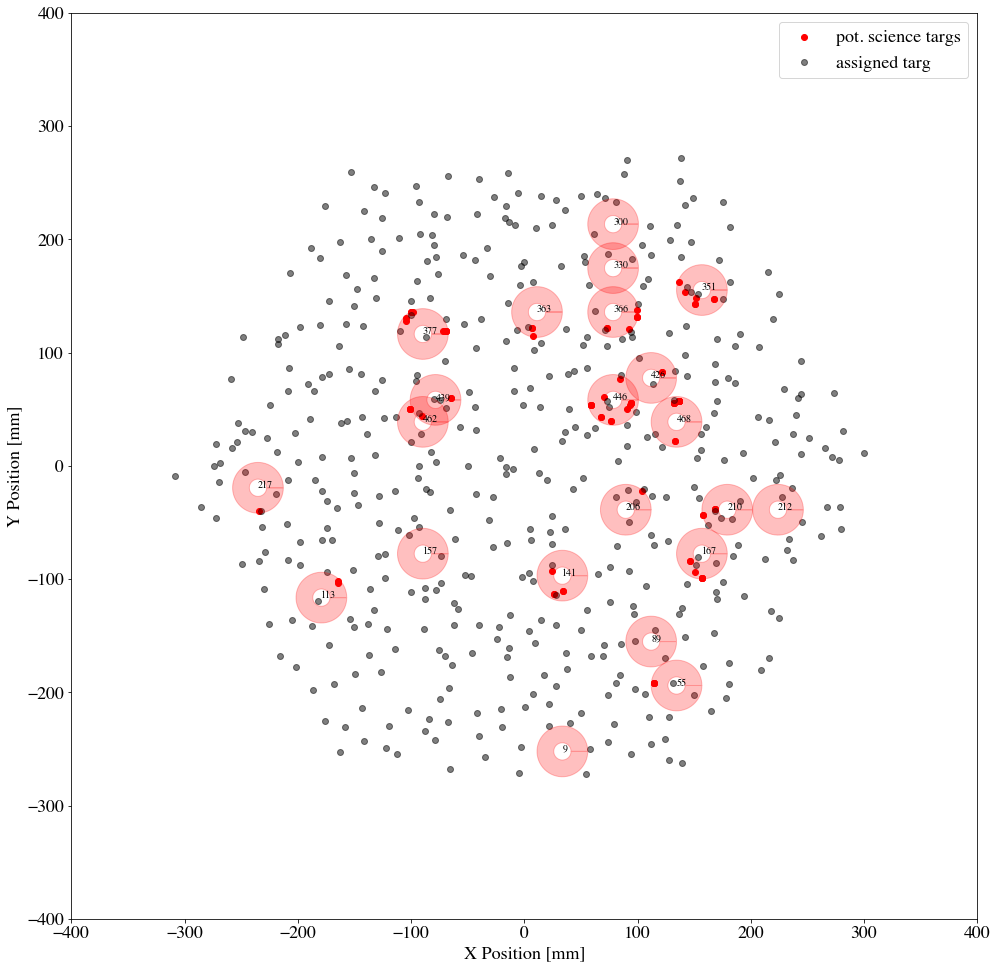

In [108]:
fig,ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_xlim(pltMin,pltMax)
ax.set_ylim(pltMin,pltMax)
ax.set_xlabel("X Position [mm]",fontsize=fontSize)
ax.set_ylabel("Y Position [mm]",fontsize=fontSize)
dpi = fig.get_dpi()
wDisp = 1200
hDisp = 1200
wInches = float(wDisp)/float(dpi)
hInches = float(hDisp)/float(dpi)
fig.set_size_inches(wInches,hInches,forward=True)
for i in range(0, len(NA_indexes)):
    plotPatrol(ax,sorted_x[NA_indexes][i],sorted_y[NA_indexes][i],r_inner,r_outer,'red','black',0.25)
for n in range(0, len(robotID[NA_indexes])):
    x_within, y_within = annulus_mask(data1['x'][only_science], data1['y'][only_science], sorted_x[NA_indexes][n], sorted_y[NA_indexes][n], 7.6, 22.4)
    assigned_mask = ((np.isin(np.array(x_within), data1['x'][assigned_all],invert=True)) &(np.isin( np.array(y_within),data1['y'][assigned_all], invert=True)))
    ax.scatter(x_within[assigned_mask], y_within[assigned_mask], c='red')
for j, txt in enumerate(robotID[NA_indexes]):
    ax.annotate(txt, (sorted_x[NA_indexes][j],  sorted_y[NA_indexes][j]),
               fontsize=10.)
ax.scatter(x_within[assigned_mask], y_within[assigned_mask], c='red', label='pot. science targs')
ax.scatter(data1['x'][assigned_all], data1['y'][assigned_all],alpha =0.5, c='black', label='assigned targ')
plt.legend()

Robot:  9
Robot position:  33.6 -252.1866
# of targets within annulus, not assigned to other robot: 0


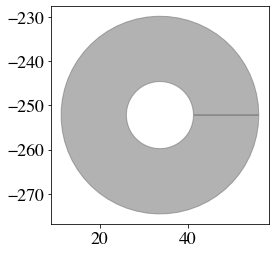

Robot:  55
Robot position:  134.4 -193.9897
# of targets within annulus, not assigned to other robot: 1


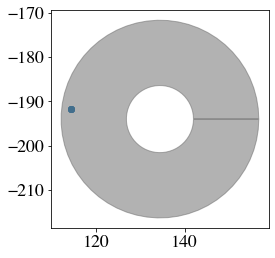

Robot:  89
Robot position:  112.0 -155.1918
# of targets within annulus, not assigned to other robot: 0


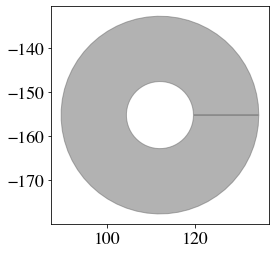

Robot:  113
Robot position:  -179.2 -116.3938
# of targets within annulus, not assigned to other robot: 2


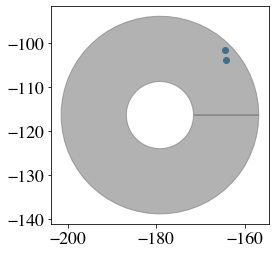

Robot:  141
Robot position:  33.6 -96.9948
# of targets within annulus, not assigned to other robot: 3


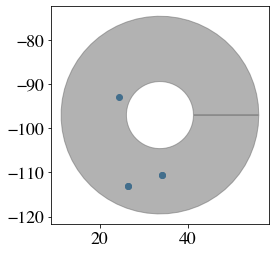

Robot:  157
Robot position:  -89.6 -77.5959
# of targets within annulus, not assigned to other robot: 0


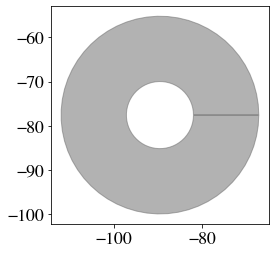

Robot:  167
Robot position:  156.8 -77.5959
# of targets within annulus, not assigned to other robot: 3


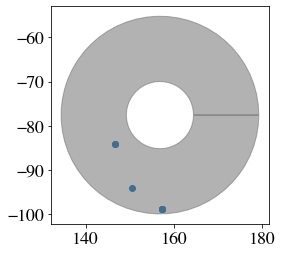

Robot:  206
Robot position:  89.6 -38.7979
# of targets within annulus, not assigned to other robot: 1


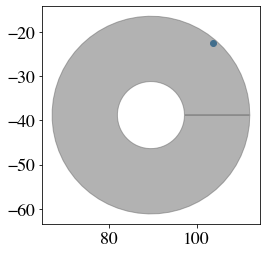

Robot:  210
Robot position:  179.2 -38.7979
# of targets within annulus, not assigned to other robot: 2


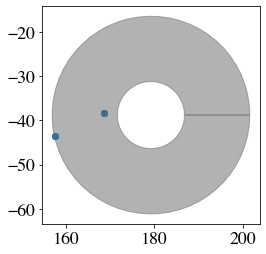

Robot:  212
Robot position:  224.0 -38.7979
# of targets within annulus, not assigned to other robot: 0


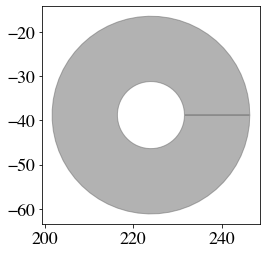

Robot:  217
Robot position:  -235.2 -19.399
# of targets within annulus, not assigned to other robot: 1


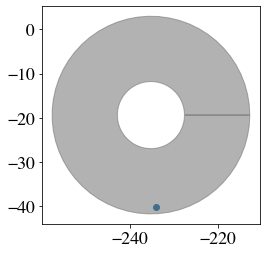

Robot:  300
Robot position:  78.4 213.3887
# of targets within annulus, not assigned to other robot: 0


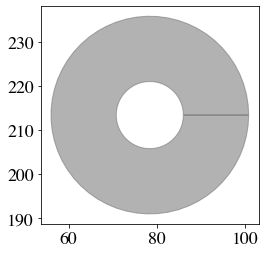

Robot:  330
Robot position:  78.4 174.5907
# of targets within annulus, not assigned to other robot: 0


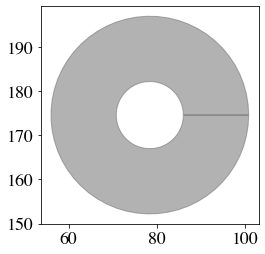

Robot:  351
Robot position:  156.8 155.1918
# of targets within annulus, not assigned to other robot: 5


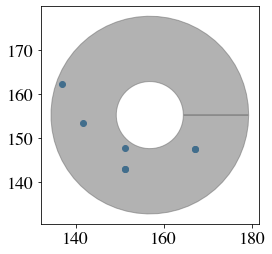

Robot:  363
Robot position:  11.2 135.7928
# of targets within annulus, not assigned to other robot: 2


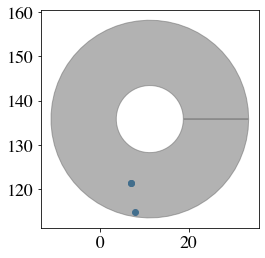

Robot:  366
Robot position:  78.4 135.7928
# of targets within annulus, not assigned to other robot: 4


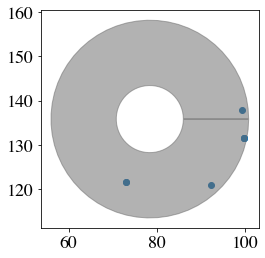

Robot:  377
Robot position:  -89.6 116.3938
# of targets within annulus, not assigned to other robot: 6


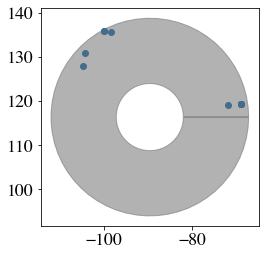

Robot:  426
Robot position:  112.0 77.5959
# of targets within annulus, not assigned to other robot: 1


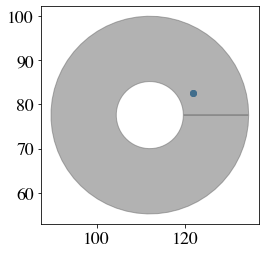

Robot:  439
Robot position:  -78.4 58.1969
# of targets within annulus, not assigned to other robot: 2


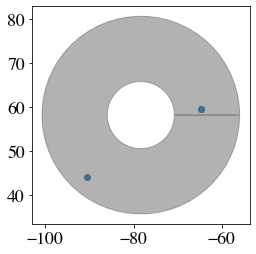

Robot:  446
Robot position:  78.4 58.1969
# of targets within annulus, not assigned to other robot: 8


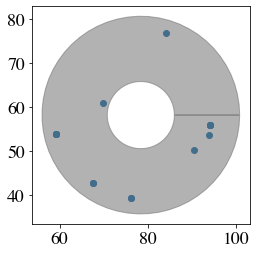

Robot:  462
Robot position:  -89.6 38.7979
# of targets within annulus, not assigned to other robot: 1


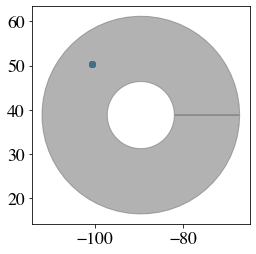

Robot:  468
Robot position:  134.4 38.7979
# of targets within annulus, not assigned to other robot: 3


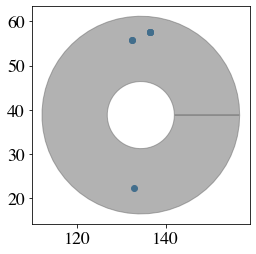

In [112]:
for n in range(0, len(robotID[NA_indexes])):
    x_within, y_within = annulus_mask(data1['x'][only_science], data1['y'][only_science], sorted_x[NA_indexes][n], sorted_y[NA_indexes][n], 7.6, 22.4)
    print("Robot: ", robotID[NA_indexes][n])
    print("Robot position: ", sorted_x[NA_indexes][n], sorted_y[NA_indexes][n])
    assigned_mask = ((np.isin(np.array(x_within), data1['x'][assigned_all],invert=True)) &(np.isin( np.array(y_within),data1['y'][assigned_all], invert=True)))
    print("# of targets within annulus, not assigned to other robot: {}".format(len(np.unique(x_within[assigned_mask]))))
    ax = plt.subplot(111, aspect='equal')
    plotPatrol(ax,sorted_x[NA_indexes][n], sorted_y[NA_indexes][n],r_inner,r_outer,baColor,'black',0.5)
    ax.scatter(x_within[assigned_mask], y_within[assigned_mask])
    plt.show()

In [57]:
# from astropy.table import Table, Column
# tab = Table()
# tab.add_column(Column(name="robotID", data=robotID, dtype='int64'))
# tab.add_column(Column(name="xpos", data=xPos2, dtype='float32'))
# tab.add_column(Column(name="ypos", data=yPos2, dtype='float32'))
# tab.write("robots.fits", format='fits', overwrite=True)

In [29]:
##argsort creates issues, it's ignoring values???
# sorted_x = []
# sorted_y = []
# robotID = []
# n= 1
# while len(yPos2) > 0:
#     min_y = np.where(yPos2 == np.min(yPos2))
#     xsort = np.argsort(xPos2[min_y])
#     print(np.min(xPos2[min_y]),np.min(yPos2))
#     for i in xPos2[min_y][xsort]:
#         sorted_x.append(i)
#         sorted_y.append(np.min(yPos2))
#         robotID.append(n)
#         n+=1
#     yPos2 = np.delete(yPos2, min_y)
    
# print(n)

In [ ]:
## maybe argsort by y position, then for each y position, argsort those xpositions
##make new arrays for x, y based on this
## use new_a = np.delete(a, index) to delete the y position once done
# for i in np.arange(0,501,1):
#     min_y = np.where(yPos2 == np.min(yPos2))
#     current_y = np.min(yPos2)
#     if len(xPos2[min_y]) > 0:
#         current_x = np.min(xPos2[min_y])
#     print(current_x, current_y)